# Import Libraries

In [1]:
import os
import sys
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split

# Environment Setup

In [2]:
ENVIRONMENT = "ada"     # set to "ada" or "colab" (or some other env name used in the script)
RUN_AS_SCRIPT = False   # set to True if running as .py
SAVE_MODEL = True       # set to False to not save model
SAVE_RESULTS = True     # set to False to not save results

In [3]:
# switch to project directory if on ada
if ENVIRONMENT == "ada":
    path = "~/projects/GNN"
    os.chdir(os.path.expanduser(path))

# create output directories
if SAVE_MODEL:
    if not os.path.exists("model"):
        os.mkdir("model")

if SAVE_RESULTS:
    if not os.path.exists("results"):
        os.mkdir("results")

In [4]:
if not RUN_AS_SCRIPT and len(sys.argv) < 3:
    print(f"USAGE: python {sys.argv[0]} <dataset> <num_epochs>", file=sys.stderr)
    sys.exit(1)

# Loading & Preprocessing the Data

In [5]:
class Dataset_Graph(object):
    def __init__(self, graph, label, node_tags=None):
        self.graph = graph
        self.label = label
        self.node_tags = node_tags
        self.node_features = None
        self.edge_matrix = None

In [6]:
def load_benchmark(name):
    path = f"data/{name}.txt"

    graph_list = list()
    label_dict = dict()
    tag_dict = dict()

    with open(path) as f:
        graph_count = int(f.readline().strip())

        for i in range(graph_count):
            row = f.readline().strip().split()
            node_count = int(row[0])
            graph_label = int(row[1])
            if not graph_label in label_dict:
                label_dict[graph_label] = len(label_dict)
            graph_label = label_dict[graph_label]

            graph = nx.Graph()
            node_tags = list()
            for j in range(node_count):
                graph.add_node(j)
                row = f.readline().strip().split()
                row_length = int(row[1]) + 2

                temp = list()
                for k in row[:row_length]:
                    temp.append(int(k))
                if temp[0] not in tag_dict:
                    tag_dict[temp[0]] = len(tag_dict)
                node_tags.append(tag_dict[temp[0]])

                for k in range(2, len(temp)):
                    graph.add_edge(j, temp[k])

            graph_list.append(Dataset_Graph(graph, graph_label, node_tags))

    for graph in graph_list:
        graph.node_features = torch.zeros(len(graph.node_tags), len(tag_dict))
        graph.node_features[range(len(graph.node_tags)), [tag for tag in graph.node_tags]] = 1

        edges = list()
        for i in graph.graph.edges():
            edges.append([i[0], i[1]])
            edges.append([i[1], i[0]])
        graph.edge_matrix = torch.LongTensor(edges).transpose(0, 1)

    print(f"Number of graphs: {len(graph_list)}")
    print(f"Number of classes: {len(label_dict)}")

    return graph_list, len(label_dict)

In [7]:
def load_data(name, graph_limit=100):
    path = f"data/{name}/{name}"

    graph_indicators = list()
    graph_db = list()
    index_offsets = list()
    label_dict = dict()
    graph_labels = list()
    graph_list = list()

    with open(path + "_graph_indicator.txt") as f:
        for i, line in enumerate(f):
            graph_indicators.append(int(line) - 1)
            if (int(line) - 1) == graph_limit:
                node_limit = i + 1
                break
    graph_count = max(graph_indicators) + 1

    index_offset = 0
    for i in range(graph_count):
        if i == graph_limit:
            break
        index_offsets.append(index_offset)
        node_count = graph_indicators.count(i)
        index_offset += node_count
        graph = nx.Graph()
        for j in range(node_count):
            graph.add_node(j)
        graph_db.append(graph)

    with open(path + "_A.txt") as f:
        for i, line in enumerate(f):
            temp = line.split(",")
            edge1 = int(temp[0].strip()) - 1
            edge2 = int(temp[1].strip()) - 1
            if edge1 >= node_limit or edge2 >= node_limit:
                break
            graph_indicator = graph_indicators[edge1]
            index_offset = index_offsets[graph_indicator]
            edge1 -= index_offset
            edge2 -= index_offset

            if ((edge1, edge2) not in list(graph_db[graph_indicator].edges())) and (
                (edge2, edge1) not in list(graph_db[graph_indicator].edges())
            ):
                graph_db[graph_indicator].add_edge(edge1, edge2)

    with open(path + "_graph_labels.txt") as f:
        for i, line in enumerate(f):
            if i == graph_limit:
                break
            graph_label = int(line)
            if not graph_label in label_dict:
                label_dict[graph_label] = len(label_dict)
            graph_label = label_dict[graph_label]
            graph_labels.append(graph_label)

    for i, graph in enumerate(graph_db):
        node_tags = [0] * graph.number_of_nodes()
        graph_list.append(Dataset_Graph(graph, graph_labels[i], node_tags))
        graph_list[i].node_features = torch.zeros(len(node_tags), 1)
        graph_list[i].node_features[
            range(len(node_tags)), [tag for tag in node_tags]
        ] = 1

        edges = list()
        for j in graph.edges():
            edges.append([j[0], j[1]])
            edges.append([j[1], j[0]])
        graph_list[i].edge_matrix = torch.LongTensor(edges).transpose(0, 1)

    print(f"Number of graphs: {len(graph_list)}")
    print(f"Number of classes: {len(label_dict)}")

    return graph_list, len(label_dict)

# Building the GIN model

In [8]:
class MLP(nn.Module):
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()

        self.num_layers = num_layers

        # define model layers
        self.linears = nn.ModuleList([nn.Linear(input_dim, output_dim if num_layers == 1 else hidden_dim)])
        
        # handle single layer perceptron case
        if num_layers > 1:
            for _ in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

        # define activation function
        self.activation = F.relu

        # define batch norms
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d((hidden_dim)) for _ in range(num_layers - 1)])

    def forward(self, x):
        for l in range(self.num_layers - 1):
            x = self.activation(self.batch_norms[l](self.linears[l](x)))

        return self.linears[-1](x)

In [9]:
class Net(nn.Module):
    def __init__(self, num_layers, num_mlp_layers, input_dim, hidden_dim, output_dim, dropout_p):
        super(Net, self).__init__()

        self.num_layers = num_layers
        self.dropout_p = dropout_p

        # initialize epsilon parameter
        self.eps = nn.Parameter(torch.zeros(self.num_layers - 1))

        # define activation function
        self.activation = F.relu

        # define list of MLPs
        self.mlp_list = nn.ModuleList([MLP(num_mlp_layers, input_dim if l == 0 else hidden_dim, hidden_dim, hidden_dim) for l in range(num_layers - 1)])

        # define batch norms
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])

        # define list of linear mapping layer
        self.linear_map = nn.ModuleList([nn.Linear(input_dim if l == 0 else hidden_dim, output_dim)for l in range(num_layers)])

    # return adjacency matrix
    def construct_adj_matrix(self, batch):
        init_indices, edge_list = [0], []

        for i in range(len(batch)):
            init_indices.append(init_indices[i] + len(batch[i].graph))
            edge_list.append(batch[i].edge_matrix + init_indices[i])

        adj_i = torch.cat(edge_list, 1)
        adj_v = torch.ones(adj_i.shape[1])

        adj_matrix = torch.sparse_coo_tensor(adj_i, adj_v, torch.Size([init_indices[-1], init_indices[-1]])).to(device)

        return adj_matrix

    # return graph pool
    def construct_pool(self, batch):
        init_indices = [0]

        for i in range(len(batch)):
            init_indices.append(init_indices[i] + len(batch[i].graph))

        gp_i = []
        gp_v = []
        for i in range(len(batch)):
            gp_v.extend([1] * len(batch[i].graph))
            gp_i.extend([[i, j] for j in range(init_indices[i], init_indices[i + 1], 1)])

        gp_v = torch.FloatTensor(gp_v)
        gp_i = torch.LongTensor(gp_i).transpose(0, 1)
        graph_pool = torch.sparse_coo_tensor(gp_i, gp_v, torch.Size([len(batch), init_indices[-1]])).to(device)

        return graph_pool

    # propagate to next layer
    def propagate(self, x, layer, adj_matrix):
        pooled = adj_matrix @ x

        pooled = pooled + (1 + self.eps[layer]) * x
        h = self.activation(self.batch_norms[layer](self.mlp_list[layer](pooled)))

        return h

    # forward propagation
    def forward(self, batch):
        X = torch.cat([graph.node_features for graph in batch], 0).to(device)

        # construct graph pool
        graph_pool = self.construct_pool(batch)

        # construct a block diagonal sparse adjacency matrix
        adj_matrix = self.construct_adj_matrix(batch)

        # store hidden representations at each layer
        hidden_reps = [X]

        # propagate through the network
        for l in range(self.num_layers - 1):
            X = self.propagate(X, l, adj_matrix)
            hidden_reps.append(X)

        # pooling
        output = 0
        for l, h in enumerate(hidden_reps):
            h_pooled = graph_pool @ h
            dropout_out = F.dropout(self.linear_map[l](h_pooled), self.dropout_p, training=self.training)
            output += dropout_out

        return output


# Training & Validating the Network

In [10]:
# function to train the model for 1 epoch
def train(model, graphs, optimizer, criterion):
    model.train()

    # iterations per epoch
    epoch_iters = 50

    # batch size per iteration
    batch_size = 32

    # maintain total loss
    total_loss = 0

    for _ in range(epoch_iters):
        selected_idx = np.random.permutation(len(graphs))[:batch_size]
        graph_batch = list(map(lambda i: graphs[i], selected_idx))

        # get model prediction
        output = model(graph_batch)

        # extract labels
        labels = torch.LongTensor(list(map(lambda g: g.label, graph_batch))).to(device)

        # compute loss
        loss = criterion(output, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # add loss to total
        loss = loss.detach().cpu().numpy()
        total_loss += loss

    avg_loss = total_loss / epoch_iters

    return avg_loss

In [11]:
# function to validate performance of model on a dataset
def evaluate(model, graphs):
    model.eval()

    # pass the data in smaller batches during testing to avoid memory overflow
    size = 64

    output = []
    idx = np.arange(len(graphs))

    for i in range(0, len(graphs), size):
        sampled_idx = idx[i:i+size]
        if len(sampled_idx):
            # output.append(model([graphs[j] for j in sampled_idx]).detach())
            output.append(model(list(map(lambda j: graphs[j], sampled_idx))).detach())
    
    output = torch.cat(output, 0)

    pred = output.max(1, keepdim=True)[1]
    labels = torch.LongTensor([graph.label for graph in graphs]).to(device)
    correct = pred.eq(labels.view_as(pred)).sum().cpu().item()

    accuracy = correct / float(len(graphs))

    return accuracy

# Configuring and Running the model

In [12]:
# available datasets
benchmark_datasets = (
    "COLLAB",
    "MUTAG",
    "PTC",
    "IMDBBINARY",
    "IMDBMULTI",
    "PROTEINS",
    "NCI1",
    "REDDITBINARY",
    "REDDITMULTI5K"
)

application_datasets = (
    "deezer_ego_nets",
    "github_stargazers",
    "twitch_egos"
)

In [13]:
# loading the data
DATASET = "MUTAG"

if RUN_AS_SCRIPT:
    DATASET = sys.argv[1]

if DATASET in application_datasets:
    graphs, num_classes = load_data(DATASET, 5000)
    print(f"Using dataset: {DATASET}")
elif DATASET in benchmark_datasets:
    graphs, num_classes = load_benchmark(DATASET)
    print(f"Using dataset: {DATASET}")
else:
    print(f"Unknown dataset. Available datasets: {benchmark_datasets + application_datasets}", file=sys.stderr)
    sys.exit(1)

# splitting the data
train_graphs, test_graphs = train_test_split(graphs, test_size=0.1)

Number of graphs: 188
Number of classes: 2
Using dataset: MUTAG


In [14]:
# hyperparameters and training config
lr = 0.01
num_epochs = 50
if RUN_AS_SCRIPT:
    num_epochs = sys.argv[2]

num_layers = 5
num_mlp_layers = 2
input_dim = train_graphs[0].node_features.shape[1]
hidden_dim = 64
output_dim = num_classes
dropout_p = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# model configuration
model = Net(num_layers, num_mlp_layers, input_dim, hidden_dim, output_dim, dropout_p).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [16]:
# train the model
loss_history = []
acc_history = {
    "train": [],
    "test": []
}

tqdm_epochs = trange(num_epochs, unit="epoch", ncols=90)
for epoch in tqdm_epochs:
    loss = train(model, train_graphs, optimizer, criterion)
    train_acc = evaluate(model, train_graphs)
    test_acc = evaluate(model, test_graphs)

    loss_history.append(loss)
    acc_history["train"].append(train_acc)
    acc_history["test"].append(test_acc)

    tqdm_epochs.set_postfix({"loss": f"{loss:.3f}", "train": f"{train_acc * 100:.2f}%", "test": f"{test_acc * 100:.2f}%"})

100%|███████████| 50/50 [00:37<00:00,  1.34epoch/s, loss=0.054, train=99.41%, test=94.74%]


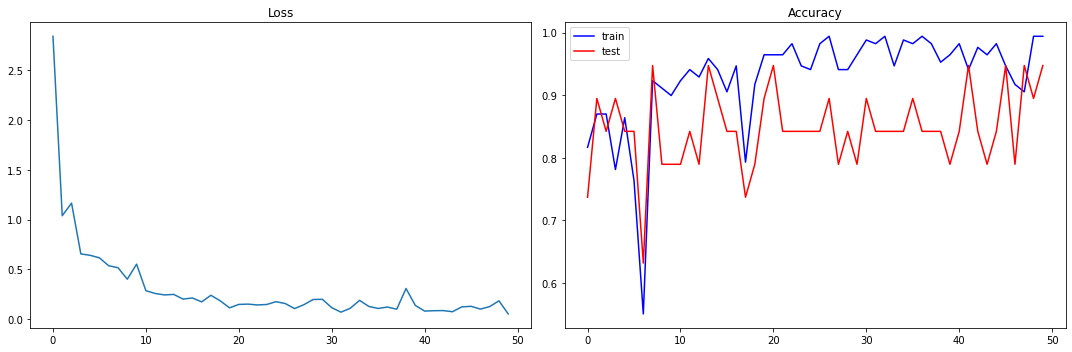

In [17]:
if not RUN_AS_SCRIPT:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(loss_history)
    plt.title("Loss")
    
    plt.subplot(122)
    plt.plot(acc_history["train"], "b", label="train")
    plt.plot(acc_history["test"], "r", label="test")
    plt.title("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Save Model

In [18]:
if SAVE_MODEL:
    model_filename = f"models/{DATASET}_{num_epochs}e.pth"
    model_file = open(model_filename, "wb")
    torch.save(model.state_dict(), model_file)
    model_file.close()
    print(f"Model saved to file: {model_filename}")

Model saved to file: models/MUTAG_50e.pth


# Save Training Results

In [19]:
if SAVE_RESULTS:
    results = {
        "loss": loss_history,
        "train_acc": acc_history["train"],
        "test_acc": acc_history["test"]
    }
    
    results_filename = f"results/{DATASET}_{num_epochs}e.pkl"
    results_file = open(results_filename, "wb")
    pickle.dump(results, results_file)
    results_file.close()
    print(f"Results saved to file: {results_filename}")

Results saved to file: results/MUTAG_50e.pkl


# Results & Analysis

In [20]:
def summarize_results(dataset):
    path = f"results/{dataset}"
    with open(path, "rb") as f:
        results = pickle.load(f)

        print(dataset.split(".")[0])
        print(f"Best train accuracy: {100 * max(results['train_acc']):.2f}%")
        print(f"Best test accuracy: {100 * max(results['test_acc']):.2f}%")
        print()

        plt.figure(figsize=(15, 5))
        
        plt.subplot(121)
        plt.plot(results["loss"])
        plt.title("Loss")
        
        plt.subplot(122)
        plt.plot(results["train_acc"], "b", label="train")
        plt.plot(results["test_acc"], "r", label="test")
        plt.title("Accuracy")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

## COLLAB

COLLAB_350e
Best train accuracy: 69.82%
Best test accuracy: 69.00%



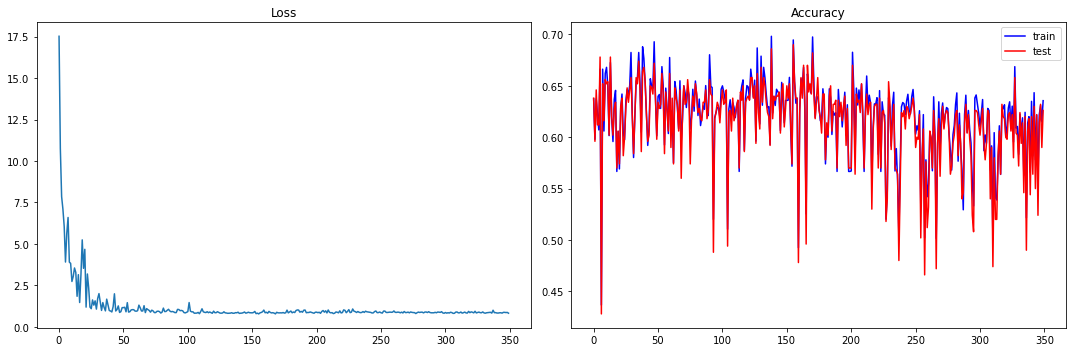

In [21]:
if not RUN_AS_SCRIPT:
    summarize_results("COLLAB_350e.pkl")

## MUTAG

MUTAG_350e
Best train accuracy: 100.00%
Best test accuracy: 94.74%



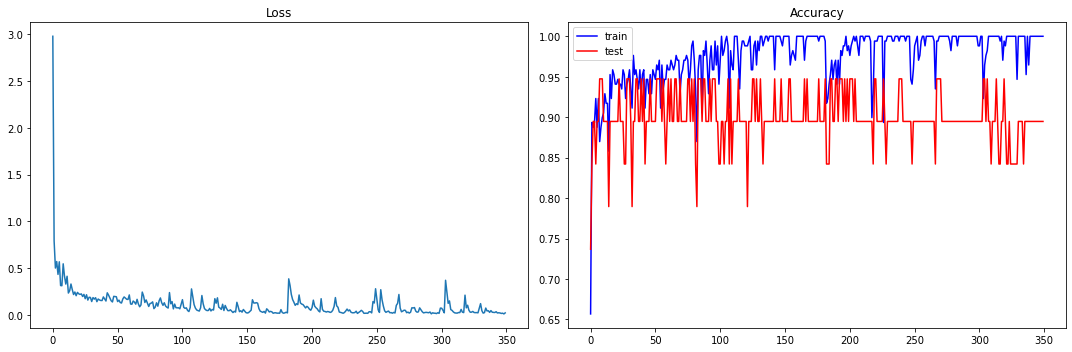

In [22]:
if not RUN_AS_SCRIPT:
    summarize_results("MUTAG_350e.pkl")

## PTC

PTC_350e
Best train accuracy: 98.71%
Best test accuracy: 71.43%



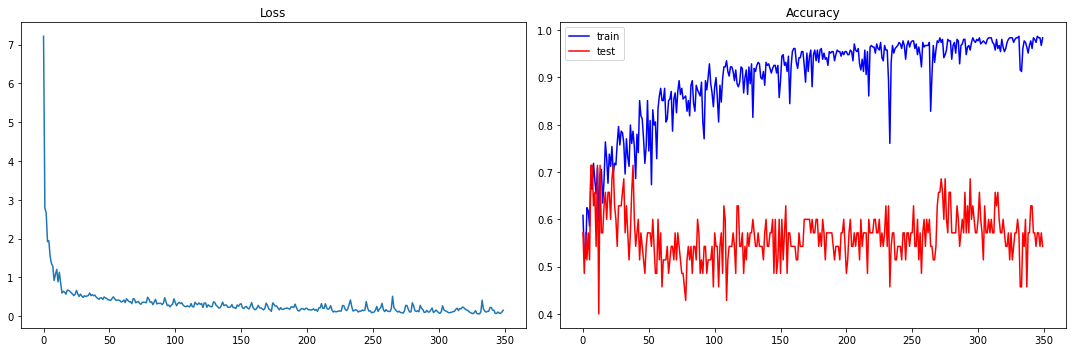

In [23]:
if not RUN_AS_SCRIPT:
    summarize_results("PTC_350e.pkl")

## IMDBBINARY

IMDBBINARY_350e
Best train accuracy: 73.44%
Best test accuracy: 75.00%



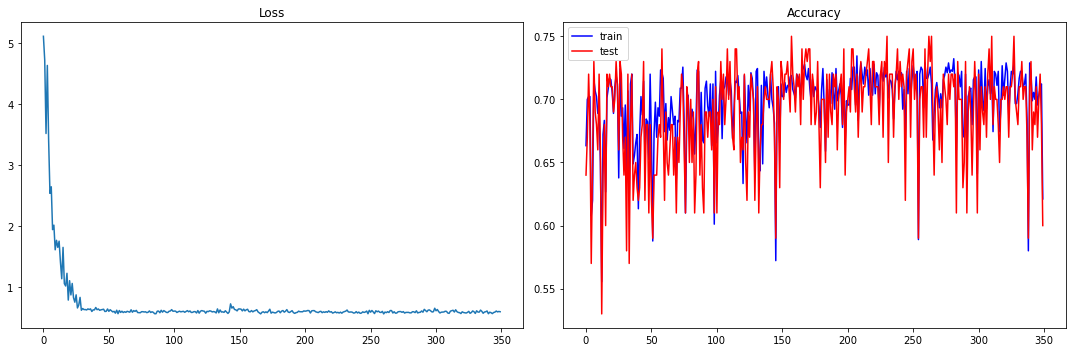

In [24]:
if not RUN_AS_SCRIPT:
    summarize_results("IMDBBINARY_350e.pkl")

## IMDBMULTI

IMDBMULTI_350e
Best train accuracy: 48.52%
Best test accuracy: 50.00%



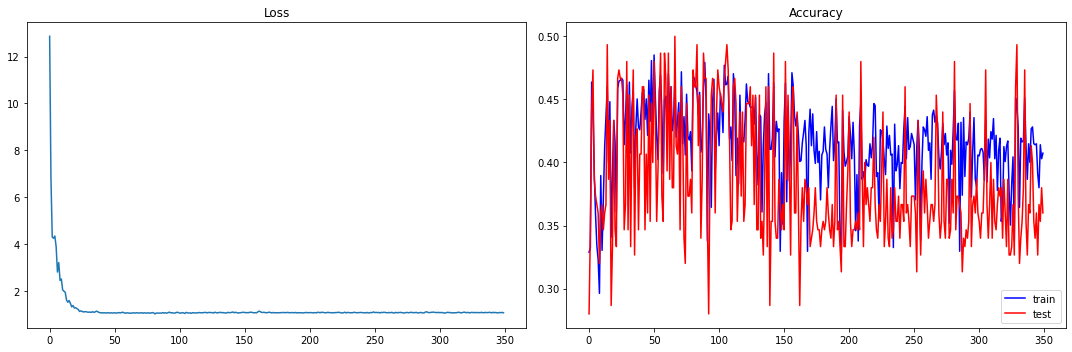

In [25]:
if not RUN_AS_SCRIPT:
    summarize_results("IMDBMULTI_350e.pkl")

## PROTEINS

PROTEINS_350e
Best train accuracy: 78.12%
Best test accuracy: 75.89%



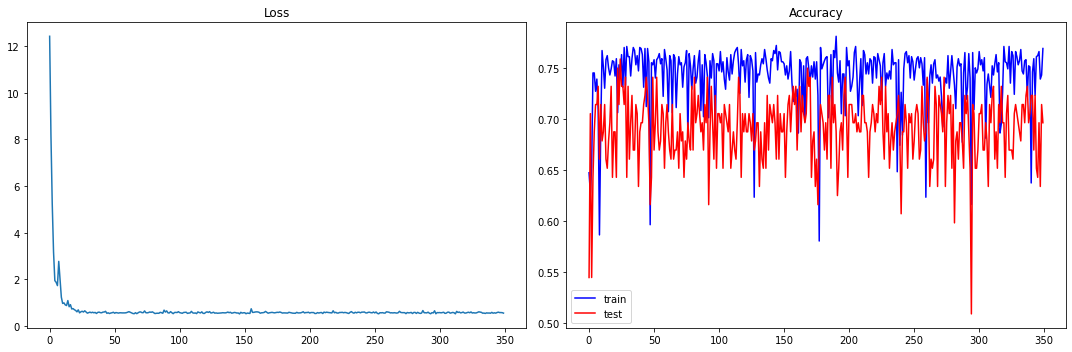

In [26]:
if not RUN_AS_SCRIPT:
    summarize_results("PROTEINS_350e.pkl")

## NCI1

NCI1_350e
Best train accuracy: 77.45%
Best test accuracy: 78.35%



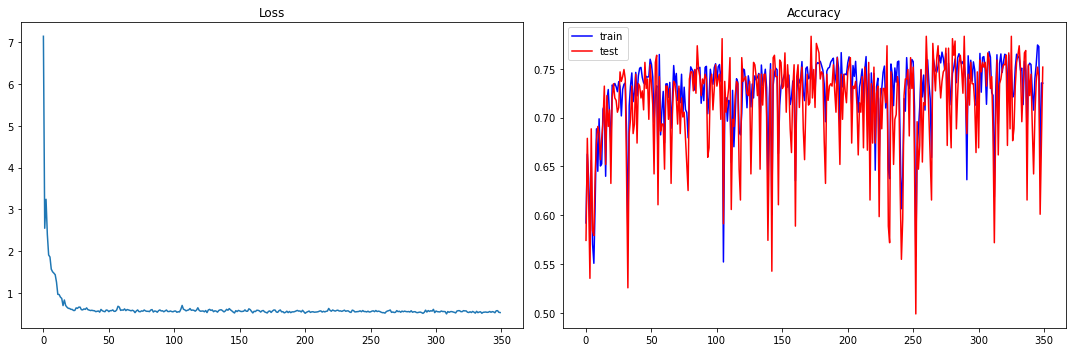

In [27]:
if not RUN_AS_SCRIPT:
    summarize_results("NCI1_350e.pkl")

## REDDITBINARY

REDDITBINARY_350e
Best train accuracy: 77.44%
Best test accuracy: 79.00%



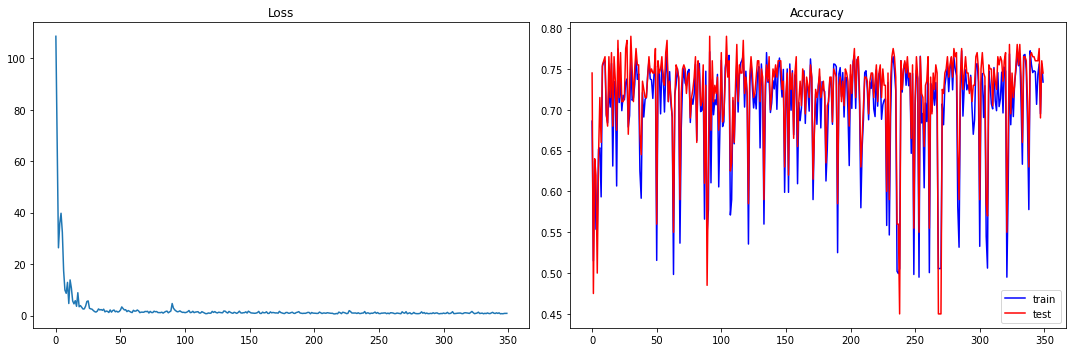

In [28]:
if not RUN_AS_SCRIPT:
    summarize_results("REDDITBINARY_350e.pkl")

## REDDITMULTI5K

REDDITMULTI5K_350e
Best train accuracy: 47.50%
Best test accuracy: 49.60%



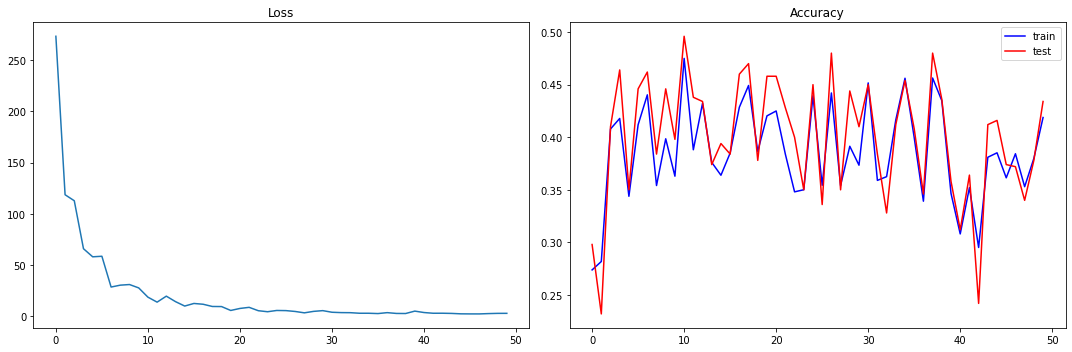

In [29]:
if not RUN_AS_SCRIPT:
    summarize_results("REDDITMULTI5K_350e.pkl")

## Deezer Ego-Nets

deezer_ego_nets_350e
Best train accuracy: 56.80%
Best test accuracy: 60.40%



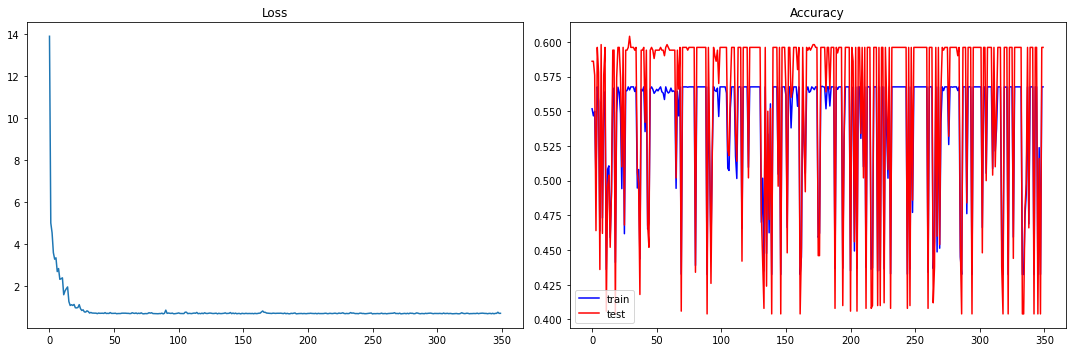

In [30]:
if not RUN_AS_SCRIPT:
    summarize_results("deezer_ego_nets_350e.pkl")

## GitHub Stargazers

github_stargazers_350e
Best train accuracy: 63.27%
Best test accuracy: 64.40%



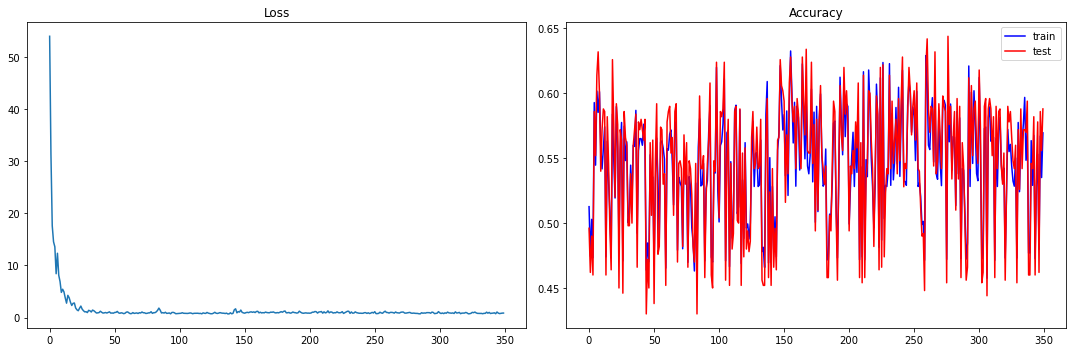

In [31]:
if not RUN_AS_SCRIPT:
    summarize_results("github_stargazers_350e.pkl")

## Twitch Egos

twitch_egos_350e
Best train accuracy: 69.22%
Best test accuracy: 68.40%



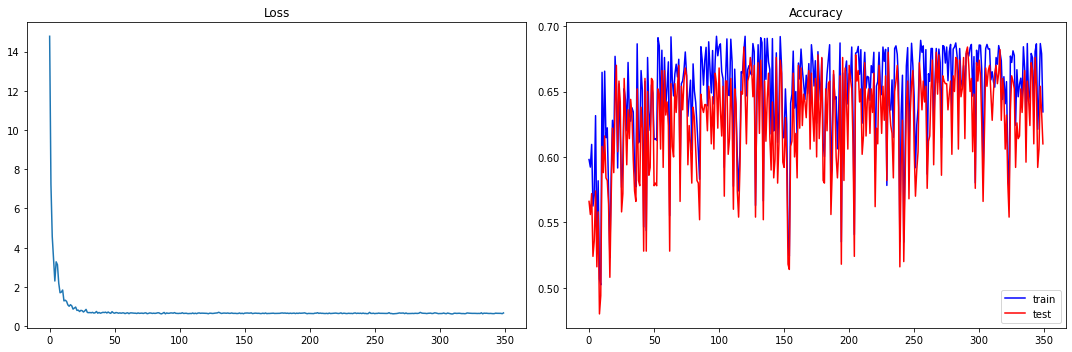

In [32]:
if not RUN_AS_SCRIPT:
    summarize_results("twitch_egos_350e.pkl")

In [33]:
def plot_attributes(attr, files):
    results = dict()
    for filename in files:
        file_d = open(f"results/{filename}", "rb")
        results[filename] = pickle.load(file_d)[attr]
        file_d.close()

    plt.figure(figsize=(20, 12))

    for i, key in enumerate(results.keys()):
        plt.subplot(3, 3, i + 1)
        plt.plot(results[key], "r")
        plt.title(key)

    plt.tight_layout()
    plt.show()